In [1]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import numpy as np
import matplotlib.pyplot as plt
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from math import pi

In [2]:
keys = (0,1,2)
fpos = ('default/defect', 'default/double_streak', 'default/wiggle')
td = read_tileset('../data/ks/tiles.h5',keys, fpos)
# td = rediscretize_tileset(td, new_shape=(128,128))

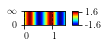

In [3]:
td[1].plot()

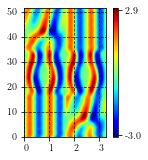

In [4]:
symbol_array = np.array([[0, 1], [2, 2], [1, 0]])
tiled_orbit = tile(symbol_array, td, OrbitKS).rescale(3).resize().transform(to='modes')
tiled_orbit.plot()

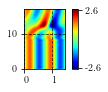

In [5]:
symbol_array = np.array([[0], [1]])
tiled_orbit = tile(symbol_array, td, RelativeOrbitKS, exclude_zero_dimensions=False).resize().transform(to='modes')
tiled_orbit.plot()

In [6]:
tiled_orbit

RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [17.151, 13.02, 0]})

In [7]:
to_result = hunt(tiled_orbit.transform(to='modes'), method='adj', verbose=True, preconditioning=True, pexp=(1,4))


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [17.151, 13.02, 0]})
Constraints : {'t': False, 'x': False, 's': False}
Initial residual : 95.36103816567305
Target residual tolerance : 0.0001024
Maximum iteration number : 16384
-------------------------------------------------------------------------------------------------
#################################################
 Residual=16.4359269 after 5000 adjoint descent steps. Parameters=(17.90005341971, 13.019401086734945, -2.4559055419293836)
#################################################
 Residual=10.5429414 after 10000 adjoint descent steps. Parameters=(18.195902924316744, 13.019330240472815, -2.466855330187784)
#################################################
 Residual=7.3913546 after 15000 adjoint descent steps. Parameters=(18.395328343544318, 13.01929293865456, -2.484

In [9]:
rpo_result = hunt(to_result.orbit, method='lstsq', verbose=True)


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [18.44, 13.019, -2.49]})
Constraints : {'t': False, 'x': False, 's': False}
Initial residual : 6.767154127361568
Target residual tolerance : 0.0001024
Maximum iteration number : 250
-------------------------------------------------------------------------------------------------
###
Converged. Exiting with residual=3.0196929179000514e-06


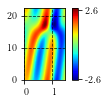

In [23]:
rpo_result.orbit.plot(fundamental_domain=False)

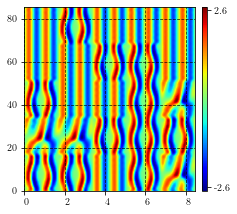

In [12]:
np.random.seed(0)
big_symbol_array = (3*np.random.rand(5, 5)).astype(int)
big_tiling = tile(big_symbol_array, td, OrbitKS, strip_wise=False, gluing_order=(1,0)).resize(64, 64)
big_tiling.plot()

In [16]:
big_tiling_result_gdnoprec = hunt(big_tiling.transform(to='modes'), comp_time='excessive', verbose=True)


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : OrbitKS({"shape": [63, 62], "basis": "modes", "parameters": [85.754, 75.155, 0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial residual : 2682.3535563564474
Target residual tolerance : 0.0004096
Maximum iteration number : 2097152
-------------------------------------------------------------------------------------------------
#################################################
 Residual=18.7139515 after 5000 adjoint descent steps. Parameters=(87.18689416924606, 82.36683705343137, 0.0)
#################################################
 Residual=10.1697637 after 10000 adjoint descent steps. Parameters=(87.85010208987991, 84.21686248446858, 0.0)
#################################################
 Residual=5.1605524 after 15000 adjoint descent steps. Parameters=(88.28434662345029, 85.54173381857477, 0.0)
######################################

#################################################
 Residual=0.7230040 after 245000 adjoint descent steps. Parameters=(91.85195161940024, 88.58205148707849, 0.0)
#################################################
 Residual=0.7156692 after 250000 adjoint descent steps. Parameters=(91.87042212529997, 88.61128940924506, 0.0)
#################################################
 Residual=0.7085019 after 255000 adjoint descent steps. Parameters=(91.88818031994258, 88.63998868397472, 0.0)
#################################################
 Residual=0.7014947 after 260000 adjoint descent steps. Parameters=(91.90525900400442, 88.6681647095796, 0.0)
#################################################
 Residual=0.6946407 after 265000 adjoint descent steps. Parameters=(91.92168959137356, 88.69583208075208, 0.0)
#################################################
 Residual=0.6879336 after 270000 adjoint descent steps. Parameters=(91.93750221121034, 88.72300461743491, 0.0)
###################################

#################################################
 Residual=0.4838521 after 500000 adjoint descent steps. Parameters=(92.34872151795904, 89.5796587072314, 0.0)
#################################################
 Residual=0.4809381 after 505000 adjoint descent steps. Parameters=(92.35581353116535, 89.59182222799721, 0.0)
#################################################
 Residual=0.4780653 after 510000 adjoint descent steps. Parameters=(92.36295524428235, 89.60378527507686, 0.0)
#################################################
 Residual=0.4752325 after 515000 adjoint descent steps. Parameters=(92.37015067118915, 89.61555217572253, 0.0)
#################################################
 Residual=0.4724388 after 520000 adjoint descent steps. Parameters=(92.37740360182745, 89.62712722298885, 0.0)
#################################################
 Residual=0.4696832 after 525000 adjoint descent steps. Parameters=(92.38471761126348, 89.63851467319104, 0.0)
###################################

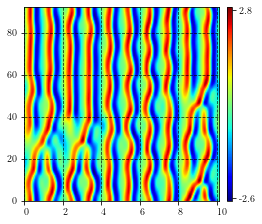

In [17]:
big_tiling_result_gdnoprec.orbit.plot()

In [18]:
big_tiling_result_gdnoprec.orbit.residual()

0.4011825716346926

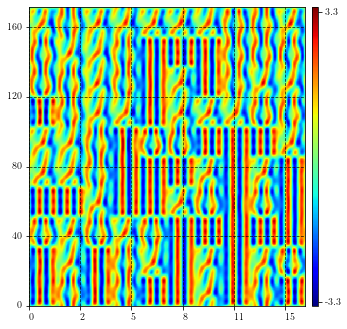

In [25]:
np.random.seed(0)
large_symbol_array = (3*np.random.rand(10, 10)).astype(int)

large_tiling = tile(large_symbol_array, td, OrbitKS, stripwise=False).reshape(64, 64).reshape().transform(to='modes')
large_tiling.plot(show=True, padding=True, padding_shape=(512, 512),
                save=True, filename='large_tiling_initial.pdf',
                directory=figs)


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial residual : 26044.02212449788
Target residual tolerance : 8.192e-06
Maximum iteration number : 4194304
Initial guess : OrbitKS({"basis": "modes", "parameters": ["171.5088", "143.7506", "0"], "field_shape": ["64", "128"]})
-------------------------------------------------------------------------------------------------
#################################################
 Residual=65.7526410 after 5000 adjoint descent steps. Parameters=(178.65630433270852, 159.3543599131507, 0)
#################################################
 Residual=35.4824437 after 10000 adjoint descent steps. Parameters=(181.0707013189993, 159.6455508677788, 0)
#################################################
 Residual=24.1965983 after 15000 adjoint descent steps. Parameters=(182.508706931639, 159.67717628176732, 0)
#################################################
 Residual=18.5875732 a

#################################################
 Residual=3.1090895 after 250000 adjoint descent steps. Parameters=(195.16513730962396, 161.58970339964972, 0)
#################################################
 Residual=3.0618972 after 255000 adjoint descent steps. Parameters=(195.30731627995675, 161.60889354927704, 0)
#################################################
 Residual=3.0164941 after 260000 adjoint descent steps. Parameters=(195.44824654546332, 161.6279802715176, 0)
#################################################
 Residual=2.9727600 after 265000 adjoint descent steps. Parameters=(195.58796768719887, 161.64698457533353, 0)
#################################################
 Residual=2.9305817 after 270000 adjoint descent steps. Parameters=(195.7265161035644, 161.66592290976484, 0)
#################################################
 Residual=2.8898536 after 275000 adjoint descent steps. Parameters=(195.86392538943971, 161.6848077530947, 0)
#####################################

#################################################
 Residual=1.2201804 after 760000 adjoint descent steps. Parameters=(205.9280032632138, 163.18733956585984, 0)
#################################################
 Residual=1.2120674 after 765000 adjoint descent steps. Parameters=(206.00964619314487, 163.19867265756662, 0)
#################################################
 Residual=1.2040417 after 770000 adjoint descent steps. Parameters=(206.0909911129538, 163.20996164578, 0)
#################################################
 Residual=1.1961028 after 775000 adjoint descent steps. Parameters=(206.17204107075773, 163.22120807592202, 0)
#################################################
 Residual=1.1882500 after 780000 adjoint descent steps. Parameters=(206.2527990430113, 163.23241338100019, 0)
#################################################
 Residual=1.1804826 after 785000 adjoint descent steps. Parameters=(206.33326793413653, 163.24357888330056, 0)
########################################

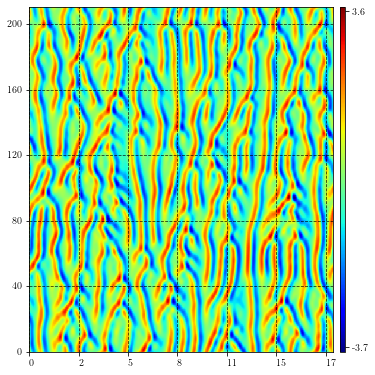

In [29]:


large_tiling_stripwise_result_gdnoprec = converge(large_tiling_stripwise, verbose=True,
                                                  preconditioning=False,comp_time='excessive')
# large_tiling_stripwise_result_gdnoprec.orbit.to_h5('large_tiling_stripwise.h5', directory='../data/local/thesis/large/')
large_tiling_stripwise_result_gdnoprec.orbit.plot(padding=True, padding_shape=(512, 512), save=True,
                                                filename='large_tiling_stripwise.pdf', 
                                                directory=figs)

In [ ]:
random_orbit_tiling_result.orbit.plot(filename='random_orbit_tiling.pdf', directory=figs)

In [22]:
o = read_h5('../data/local/OrbitKS.h5','t46p754_x31p245', state_type='field')
r = read_h5('../data/local/OrbitKS.h5','t65p638_x38p516', state_type='field')

# r = read_h5('OrbitKS_L38p516_T65p638.h5', state_type='field')

In [3]:
from orbithunter.gluing import expensive_glue
o1 = read_h5('../data/local/ShiftReflectionOrbitKS.h5', 't93p804_x22p000')
o2 = read_h5('../data/local/ShiftReflectionOrbitKS.h5', 't30p451_x34p465')
expensive_glue(np.array([[o1],[o2]]), ShiftReflectionOrbitKS)

In [4]:
from orbithunter.gluing import expensive_glue

In [5]:
expensive_glue(np.array([[o1],[o2]]), ShiftReflectionOrbitKS)

IndexError: tuple index out of range

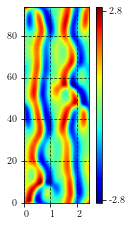

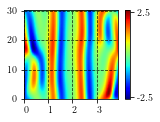

(None, None)

In [30]:
o1.plot(), o2.plot()

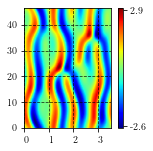

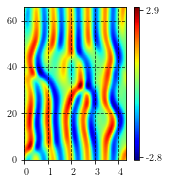

In [25]:
o.plot() 
r.plot()

In [ ]:
datadir = '../../data/ks/examples/gluing/'
o0=read_h5('OrbitKS_T41p382_L38p050.h5', directory=datadir).reshape(512,512).transform(to='field')
o1=read_h5('OrbitKS_T46p754_L31p245.h5', directory=datadir).reshape(512,512).transform(to='field')
o2=read_h5('OrbitKS_T43p819_L34p784.h5', directory=datadir).reshape(512,512).transform(to='field')
o3=read_h5('OrbitKS_T36p167_L25p720.h5', directory=datadir).reshape(512,512).transform(to='field')
o4 = convert_class(read_h5('RelativeOrbitKS_T69p300_L24p069.h5').reshape(512,512).change_reference_frame(to='physical').transform(to='field'), OrbitKS)

In [ ]:
big_tiling_stripwise_result_gd = converge(big_tiling_stripwise, verbose=True)
big_tiling_stripwise_result_gd.orbit.to_h5('OrbitKS_big_tiling_stripwise_gd.h5', directory='../data/local/testing/')

In [ ]:
big_tiling_stripwise_result_gd.orbit.plot()

In [ ]:
np.random.seed(432)
symbol_array = 3*np.random.rand(30, 30).astype(int)
huge_tiling = tile(symbol_array, td, OrbitKS).reshape(512, 512).transform(to='modes')

In [ ]:
from orbithunter.gluing import tile_dictionary_ks
td = rediscretize_tiling_dictionary(tile_dictionary_ks(), new_shape=(256,256))

np.random.seed(432)
symbol_array = (3*np.random.rand(30, 30)).astype(int)
huge_tiling_stripwise = tile(symbol_array, td, OrbitKS, stripwise=True,
                             gluing_order=(1,0)).reshape(256, 512).transform(to='modes')

huge_tiling_stripwise.to_h5(filename='OrbitKS_huge_tiling_stripwise_10_initial.h5', directory='../data/local/testing/')
huge_tiling_stripwise.plot(show=False, padding=True, padding_shape=(2048, 2048), save=True, filename='OrbitKS_huge_tiling_stripwise_10_initial.png', directory='../data/local/testing/')
huge_tiling_stripwise.plot(padding=True, padding_shape=(2048, 2048), save=True, filename='OrbitKS_huge_tiling_stripwise_10_initial.pdf', directory='../data/local/testing/')

In [ ]:
huge_tiling_stripwise_result_minres = converge(huge_tiling_stripwise, verbose=True, orbit_maxiter=1000,
                                               method='minres',scipy_kwargs={'tol': 1e-8})
huge_tiling_stripwise_result_minres.orbit.to_h5('OrbitKS_huge_tiling_minres.h5', directory='../data/local/testing/')

In [ ]:
huge_tiling_stripwise_result_minres.orbit.plot(filename='OrbitKS_huge_tiling_minres.png', directory='../data/local/testing/', padding=True, padding_shape=(2048, 2048))
huge_tiling_stripwise_result_minres.orbit.plot(filename='OrbitKS_huge_tiling_minres.pdf', directory='../data/local/testing/', show=False, padding=True, padding_shape=(2048, 2048))

In [ ]:
from orbithunter.gluing import tile_dictionary_ks
td = rediscretize_tiling_dictionary(tile_dictionary_ks(padded=False, comoving=True), new_shape=(256,256))
# td[3] = td[1].reflection()
np.random.seed(432)
symbol_array = (4*np.random.rand(30, 30)).astype(int)

td = rediscretize_tiling_dictionary(tile_dictionary_ks(), new_shape=(256,256))
tdr = rediscretize_tiling_dictionary(tile_dictionary_ks(padded=False, comoving=True), new_shape=(256,256))
tdl = tdr.copy()
td_dict = {0: tdl, 1: tdr, 2: td}

local_tiles = []
for s in range(9):
    np.random.seed(s)
    symbol_array = (3*np.random.rand(10, 10)).astype(int)
    np.random.seed(s)
    local_shift_dict = td_dict[int(2*np.random.rand())] 
    local_tiles.append(tile(symbol_array, local_shift_dict, OrbitKS, stripwise=True, gluing_order=(1,0)))

full_tiling_with_local_shifts = glue(np.array(local_tiles).reshape(3,3), OrbitKS, stripwise=True, gluing_order=(1,0))

full_tiling_with_local_shifts.plot()

tiling_with_local_shifts = full_tiling_with_local_shifts.reshape(256, 512)

tiling_with_local_shifts.plot()

tiling_with_local_shifts.to_h5(filename='OrbitKS_huge_tiling_local_velocity_initial.h5', directory='../data/local/testing/')
tiling_with_local_shifts.plot(show=False, padding=True, padding_shape=(2048, 2048), save=True, filename='OrbitKS_huge_tiling_local_velocity_initial.png', directory='../data/local/testing/')
tiling_with_local_shifts.plot(padding=True, padding_shape=(2048, 2048), save=True, filename='OrbitKS_huge_tiling_local_velocity_initial.pdf', directory='../data/local/testing/')

tiling_with_local_shifts_result_minres = converge(tiling_with_local_shifts, verbose=True, orbit_maxiter=1000,
                                               method='minres',scipy_kwargs={'tol': 1e-8})
tiling_with_local_shifts_result_minres.orbit.to_h5('OrbitKS_huge_tiling_local_velocity_minres.h5', directory='../data/local/testing/')

tiling_local_velocity_phase2 = tiling_with_local_shifts_result_minres.orbit

tiling_local_velocity_phase2.plot(show=False, padding=True, padding_shape=(2048, 2048), 
                                            save=True, filename='OrbitKS_huge_tiling_local_velocity_minres.png', 
                                            directory='../data/local/testing/')
tiling_local_velocity_phase2.plot(padding=True, padding_shape=(2048, 2048),
                                            save=True, filename='OrbitKS_huge_tiling_local_velocity_minres.pdf',
                                            directory='../data/local/testing/')

local_tiles = []
for s in range(9):
    np.random.seed(s)
    symbol_array = (3*np.random.rand(10, 10)).astype(int)
    np.random.seed(s)
    local_shift_dict = td_dict[int(2*np.random.rand())] 
    local_tiles.append(tile(symbol_array, local_shift_dict, OrbitKS, stripwise=True, gluing_order=(1,0)))